# Data Routing and Query Construction

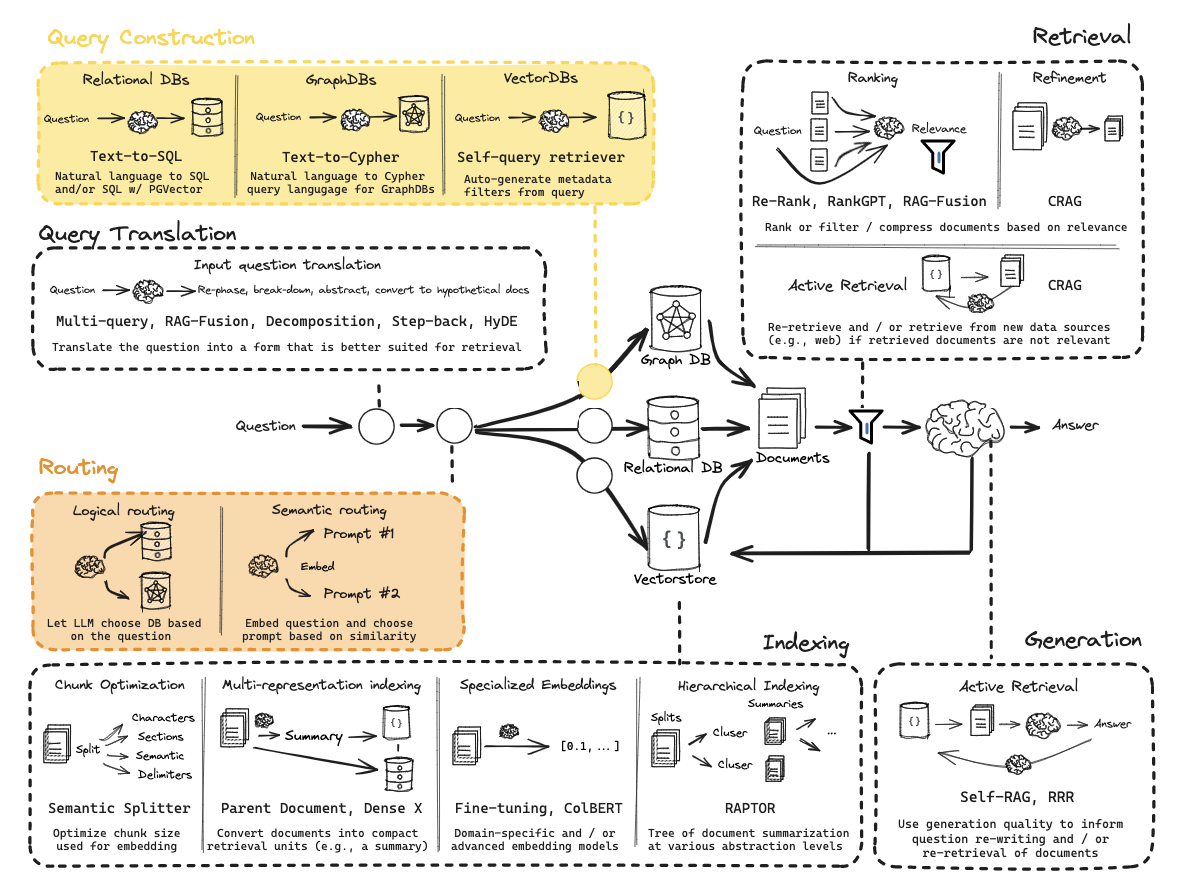

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import os
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_PROJECT'] = 'advanced-rag'
os.environ['LANGCHAIN_API_KEY'] = os.getenv("LANGCHAIN_API_KEY")


## Routing

Routing in AI systems, particularly in language models and conversational AI, refers to the process of directing inputs or queries to the most appropriate component or model for handling. It's a way to create more dynamic and adaptable AI systems that can respond to a variety of inputs more effectively.



Routing allows you to create non-deterministic chains where the output of a previous step defines the next step. Routing can help provide structure and consistency around interactions with models by allowing you to define states and use information related to those states as context to model calls.

There are two ways to perform routing:

1. Conditionally return runnables from a [RunnableLambda](https://python.langchain.com/docs/how_to/functions/) (recommended)
2. Using a RunnableBranch (legacy)

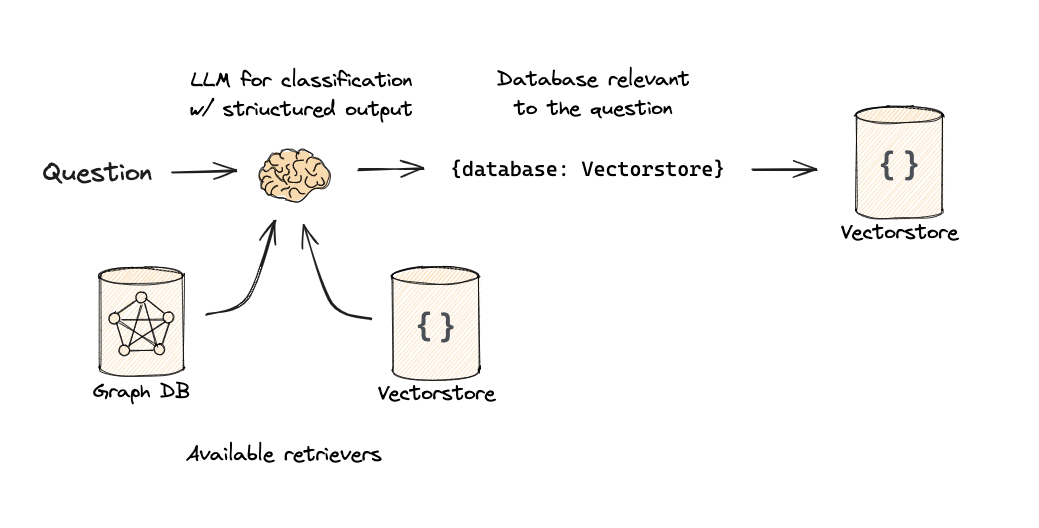

In [7]:
from langchain_ollama import ChatOllama
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate

chain = (
    PromptTemplate.from_template(
        """Given the user question below, classify it as either being about `LangChain`, `Anthropic`, 'Ollama' or `Other`.

Do not respond with more than one word [`LangChain`, `Anthropic`, 'Ollama' , `Other`].

<question>
{question}
</question>

Classification:"""
    )
    | ChatOllama(model="llama3.1")
    | StrOutputParser()
)

chain.invoke({"question": "how do I call Llama3.1?"})

'Ollama'

In [8]:
langchain_chain = PromptTemplate.from_template(
    """You are an expert in langchain. \
Always answer questions starting with "As Harrison Chase told me". \
Respond to the following question:

Question: {question}
Answer:"""
) | ChatOllama(model="llama3.1")


anthropic_chain = PromptTemplate.from_template(
    """You are an expert in anthropic. \
Always answer questions starting with "As Dario Amodei told me". \
Respond to the following question:

Question: {question}
Answer:"""
) | ChatOllama(model="llama3.1")

ollama_chain = PromptTemplate.from_template(
    """You are an expert in ollama. \
Always answer questions starting with "As Michael Chiang and Jeffrey Morgan told me". \
Respond to the following question:

Question: {question}
Answer:"""
) | ChatOllama(model="llama3.1")

general_chain = PromptTemplate.from_template(
    """Respond to the following question:

Question: {question}
Answer:"""
) | ChatOllama(model="llama3.1")

### Using a custom function (Recommended)

**Custom Function Routing:** A custom function is defined to determine which chain to use based on the input. This method is more flexible and easier to maintain.



In [9]:
def route(info):
    if "anthropic" in info["topic"].lower():
        return anthropic_chain
    elif "langchain" in info["topic"].lower():
        return langchain_chain
    elif "ollama" in info["topic"].lower():
        return ollama_chain
    else:
        return general_chain

In [10]:
from langchain_core.runnables import RunnableLambda

full_chain = {"topic": chain, "question": lambda x: x["question"]} | RunnableLambda(
    route
)

In [11]:
full_chain.invoke({"question": "how do I use ollama?"})

AIMessage(content="As Harrison Chase told me, OLLAMA (One-Layer Large Language Model for Massive Action) is a powerful tool that allows you to have open-ended conversations and creative collaborations with AI models. To use OLLAMA effectively, follow these steps:\n\n1. **Understand the limitations**: Keep in mind that OLLAMA is designed for more fluid and less structured interactions compared to traditional chatbots or language models.\n2. **Start with a clear objective or prompt**: While not strictly necessary, defining what you want to achieve or discuss can help guide the conversation. This could be anything from exploring a topic in-depth to generating creative content.\n3. **Engage in natural-sounding dialogue**: OLLAMA encourages interaction that simulates how humans communicate. Feel free to ask questions, share your thoughts, and build upon the responses you receive.\n4. **Be flexible and open-minded**: The conversations can evolve unpredictably, so be prepared to adapt and exp

In [12]:
full_chain.invoke({"question": "how do I use LangChain?"})

AIMessage(content='I\'m happy to help! As Harrison Chase told me, one of the most effective ways to get started with LangChain is by breaking down your problem into a series of tasks that can be performed by individual models or modules.\n\nLangChain allows you to chain together different LLMs (Large Language Models), APIs, and other tools to create a workflow that solves a complex problem. To use LangChain, you\'ll need to define a sequence of operations, called "pipelines," which specify how each component should interact with the others.\n\nHere are the general steps As Harrison Chase told me:\n\n1. **Define your pipeline**: Identify the tasks you want to perform and the models or APIs that can help you achieve those tasks.\n2. **Connect the components**: Use LangChain\'s built-in support for popular AI libraries like Hugging Face Transformers, as well as other tools and APIs, to connect the different modules in your pipeline.\n3. **Run the pipeline**: Execute the workflow by provid

In [13]:
full_chain.invoke({"question": "How many r in strawberry"})

AIMessage(content='There are 2 Rs in "strawberry".', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-09-22T15:50:32.7652454Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 3513474900, 'load_duration': 35599300, 'prompt_eval_count': 27, 'prompt_eval_duration': 1679524000, 'eval_count': 12, 'eval_duration': 1797021000}, id='run-5e79b1da-8680-41fc-89df-37b86c8a84c5-0', usage_metadata={'input_tokens': 27, 'output_tokens': 12, 'total_tokens': 39})

### Using a RunnableBranch


This is a special type of runnable that defines a set of conditions and corresponding runnables. It selects the first condition that evaluates to True and runs the corresponding runnable. While functional, it's considered less flexible than the custom function approach.

Here's an example of what it looks like in action:

In [ ]:
from langchain_core.runnables import RunnableBranch

branch = RunnableBranch(
    (lambda x: "anthropic" in x["topic"].lower(), anthropic_chain),
    (lambda x: "langchain" in x["topic"].lower(), langchain_chain),
    (lambda x: "ollama" in x["topic"].lower(), ollama_chain),
    general_chain,
)
full_chain = {"topic": chain, "question": lambda x: x["question"]} | branch
full_chain.invoke({"question": "how do I use Anthropic?"})

In [ ]:
full_chain.invoke({"question": "how do I use ollama?"})

In [ ]:
full_chain.invoke({"question": "how do I use LangChain?"})

In [ ]:
full_chain.invoke({"question": "How many r in strawberry"})

### Query analysis


We can use query analysis to improve the results of retrieval. This will involve defining a query schema that contains some date filters and use a function-calling model to convert a user question into a structured queries.



#### Query schema


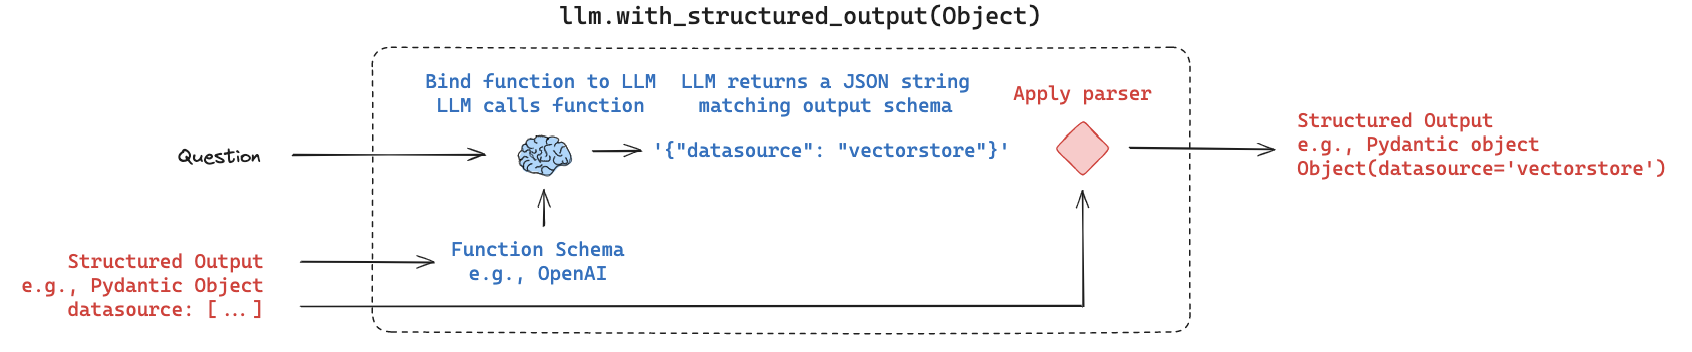

In [ ]:
from pydantic import BaseModel
from typing import Literal, Field
# Data model

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["LangChain", "Anthropic", "Ollama",'Other'] = Field(
        ...,
        description="Given a user question choose which datasource would be most relevant for answering their question",
    )

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

# LLM with function call 
llm = ChatOllama(model = 'llama3.1',temperature=0)
structured_llm = llm.with_structured_output(RouteQuery)

# Prompt 
system = """You are an expert at routing a user question to the appropriate data source.

Based on the programming language the question is referring to, route it to the relevant data source."""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

# Define router 
router = prompt | structured_llm

In [ ]:
question = "how do I use llama3.1 from ollama?"
result = router.invoke({"question": question})
print(f"The result is {result}\n",'-'*75,'Data source is {result.datasource}')

### Routing by semantic similarity


One especially useful technique is to use embeddings to route a query to the most relevant prompt. Here's an example.



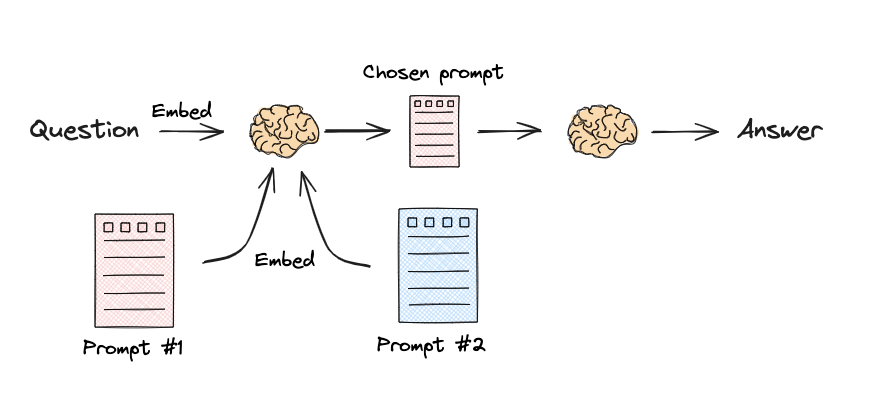

In [15]:
from langchain_community.utils.math import cosine_similarity
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from langchain_ollama import OllamaEmbeddings

physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise and easy to understand manner. \
When you don't know the answer to a question you admit that you don't know.

Here is a question:
{query}"""

math_template = """You are a very good mathematician. You are great at answering math questions. \
You are so good because you are able to break down hard problems into their component parts, \
answer the component parts, and then put them together to answer the broader question.

Here is a question:
{query}"""

embeddings = OllamaEmbeddings(model = 'mxbai-embed-large')
prompt_templates = [physics_template, math_template]
prompt_embeddings = embeddings.embed_documents(prompt_templates)


def prompt_router(input):
    query_embedding = embeddings.embed_query(input["query"])
    similarity = cosine_similarity([query_embedding], prompt_embeddings)[0]
    most_similar = prompt_templates[similarity.argmax()]
    print("Using MATH" if most_similar == math_template else "Using PHYSICS")
    return PromptTemplate.from_template(most_similar)


chain = (
    {"query": RunnablePassthrough()}
    | RunnableLambda(prompt_router)
    | ChatOllama(model="llama3.1")
    | StrOutputParser()
)

In [16]:
print(chain.invoke("What's a black hole"))

Using PHYSICS
A great question! A black hole is indeed a fascinating phenomenon in physics.

A black hole is a region in space where the gravitational pull is so strong that nothing, including light, can escape. It's formed when a massive star collapses in on itself and its gravity becomes so intense that it warps the fabric of spacetime around it.

Imagine you're standing near a very heavy object, like a mountain. The force of gravity pulls you towards the mountain, right? Now imagine that object is so massive that its gravity is not just pulling you towards it, but also bending the space around it in such a way that anything that gets too close, including light, gets sucked in and can't escape.

That's basically what a black hole is. The point of no return, where the gravity is so strong that not even light can get out, is called the event horizon. Once you cross the event horizon, you're trapped, and there's no coming back.

Black holes come in different sizes, from small, stellar-m

In [17]:
print(chain.invoke("What's a path integral"))

Using MATH
A path integral! That sounds like a nice challenge.

First, let me break down what I think you might be getting at. A "path" implies a trajectory or a course that something follows over time. An "integral" usually means we're looking to sum up some quantity along the way.

So, in this case, a path integral likely involves integrating some function over all possible paths or trajectories of interest.

Let me try to break it down further:

1. **Path**: What kind of paths are we talking about? Are they geometric paths in space-time (e.g., curves in R^n), or perhaps stochastic paths (random walks)?
2. **Integral**: What is the quantity being integrated? Is it a physical observable, like energy or momentum, or something else entirely?

Assuming I'm on the right track, I'll take a stab at it...

A path integral might be related to the concept of a "sum over all possible paths," which is often used in quantum mechanics and statistical mechanics. In these contexts, the path integral

## Query construction 

Query construction is the process of transforming a user's query or request into a structured format that can be effectively used to search a database or information retrieval system. It's a crucial step in many information retrieval and question-answering systems, particularly those dealing with unstructured or semi-structured data.

### The Query Construction Process



1. **Natural Language Understanding:** This involves parsing the user's input to identify key terms, entities, and the overall intent of the query.
2. **Query Formulation:** Based on the understood intent, a structured query is created. This might involve:

    - Selecting relevant fields to search
    - Applying filters or constraints
    - Determining the type of search (e.g., exact match, fuzzy search, semantic search)


3. **Query Expansion:** Sometimes, the original query is expanded to include synonyms, related terms, or additional context to improve recall.
4. **Query Optimization:** The constructed query might be further refined to ensure efficient execution against the target database or search system.

##### Importing Libraries and Setting Up Data


In [56]:
from langchain_community.document_loaders import YoutubeLoader
from pydantic import BaseModel

urls = [
    "https://www.youtube.com/watch?v=HAn9vnJy6S4",
    "https://www.youtube.com/watch?v=dA1cHGACXCo",
    "https://www.youtube.com/watch?v=ZcEMLz27sL4",
    "https://www.youtube.com/watch?v=hvAPnpSfSGo",
    "https://www.youtube.com/watch?v=EhlPDL4QrWY",
    "https://www.youtube.com/watch?v=mmBo8nlu2j0",
    "https://www.youtube.com/watch?v=rQdibOsL1ps",
    "https://www.youtube.com/watch?v=28lC4fqukoc",
    "https://www.youtube.com/watch?v=es-9MgxB-uc",
    "https://www.youtube.com/watch?v=wLRHwKuKvOE",
    "https://www.youtube.com/watch?v=ObIltMaRJvY",
    "https://www.youtube.com/watch?v=DjuXACWYkkU",
    "https://www.youtube.com/watch?v=o7C9ld6Ln-M"
]
docs = []
for url in urls:
    docs.extend(YoutubeLoader.from_youtube_url(url, add_video_info=True).load())

##### Adding Metadata


In [57]:
import datetime

# Add some additional metadata: what year the video was published
for doc in docs:
    doc.metadata["publish_year"] = int(
        datetime.datetime.strptime(
            doc.metadata["publish_date"], "%Y-%m-%d %H:%M:%S"
        ).strftime("%Y")
    )

In [58]:
[doc.metadata["title"] for doc in docs]

['OpenGPTs',
 'Building a web RAG chatbot: using LangChain, Exa (prev. Metaphor), LangSmith, and Hosted Langserve',
 'Streaming Events: Introducing a new `stream_events` method',
 'LangGraph: Multi-Agent Workflows',
 'Build and Deploy a RAG app with Pinecone Serverless',
 'Auto-Prompt Builder (with Hosted LangServe)',
 'Build a Full Stack RAG App With TypeScript',
 'Getting Started with Multi-Modal LLMs',
 'SQL Research Assistant',
 'Skeleton-of-Thought: Building a New Template from Scratch',
 'Benchmarking RAG over LangChain Docs',
 'Building a Research Assistant from Scratch',
 'LangServe and LangChain Templates Webinar']

In [12]:
docs[0].metadata



{'source': 'HAn9vnJy6S4',
 'title': 'OpenGPTs',
 'description': 'Unknown',
 'view_count': 9371,
 'thumbnail_url': 'https://i.ytimg.com/vi/HAn9vnJy6S4/hq720.jpg',
 'publish_date': '2024-01-31 00:00:00',
 'length': 1530,
 'author': 'LangChain',
 'publish_year': 2024}

##### Creating the Vector Database


In [59]:
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000)
chunked_docs = text_splitter.split_documents(docs)
embeddings = OllamaEmbeddings(model="mxbai-embed-large")
vectorstore = Chroma.from_documents(
    chunked_docs,
    embeddings,
)

In [14]:
search_results = vectorstore.similarity_search("how do I build a RAG agent")
print(search_results[0].metadata["title"])
print(search_results[0].page_content[:500])

LangGraph: Multi-Agent Workflows
to set up everything we've need I've already done this um importantly we're going to be using Lang Smith here to kind of like track the the multi-agents and see what's going on for for a really good debugging experience um Lang Smith right now is in private beta if you don't have access shoot me a DM on LinkedIn or Twitter and we can get you access so the first thing we're going to do do is we're going to Define this helper function that creates an agent so basically we're going to create uh the


In [15]:
search_results = vectorstore.similarity_search("videos on RAG published in 2023")
print(search_results[0].metadata["title"])
print(search_results[0].metadata["publish_date"])
print(search_results[0].page_content[:500])

OpenGPTs
2024-01-31 00:00:00
hardcoded that it will always do a retrieval step here the assistant decides whether to do a retrieval step or not sometimes this is good sometimes this is bad sometimes it you don't need to do a retrieval step when I said hi it didn't need to call it tool um but other times you know the the llm might mess up and not realize that it needs to do a retrieval step and so the rag bot will always do a retrieval step so it's more focused there because this is also a simpler architecture so it's always


In [30]:
search_results[0].metadata['publish_year']

2024

##### Defining the Query Structure


In [60]:
import datetime
from typing import Literal, Optional, Tuple
from pydantic import BaseModel, Field

class TutorialSearch(BaseModel):
    """Search over a database of tutorial videos about a software library."""

    content_search: str = Field(
        ...,
        description="Similarity search query applied to video transcripts.",
    )
    title_search: str = Field(
        ...,
        description=(
            "Alternate version of the content search query to apply to video titles. "
            "Should be succinct and only include key words that could be in a video "
            "title."
        ),
    )
    publish_year: Optional[int] = Field(
        None,
        description="Year video was published")
    min_view_count: Optional[int] = Field(
        None,
        description="Minimum view count filter, inclusive. Only use if explicitly specified.",
    )
    max_view_count: Optional[int] = Field(
        None,
        description="Maximum view count filter, exclusive. Only use if explicitly specified.",
    )
    earliest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Earliest publish date filter, inclusive. Only use if explicitly specified.",
    )
    latest_publish_date: Optional[datetime.date] = Field(
        None,
        description="Latest publish date filter, exclusive. Only use if explicitly specified.",
    )
    min_length_sec: Optional[int] = Field(
        None,
        description="Minimum video length in seconds, inclusive. Only use if explicitly specified.",
    )
    max_length_sec: Optional[int] = Field(
        None,
        description="Maximum video length in seconds, exclusive. Only use if explicitly specified.",
    )



##### Setting Up the Query Analyzer


In [61]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

from langchain_ollama import ChatOllama
system = """You are an expert at converting user questions into database queries. \
You have access to a database of tutorial videos about a software library for building LLM-powered applications. \
Given a question, return a list of database queries optimized to retrieve the most relevant results.

If there are acronyms or words you are not familiar with, do not try to rephrase them."""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)
llm = ChatOllama(model='llama3.1')
structured_llm = llm.with_structured_output(TutorialSearch)
query_analyzer = {"question": RunnablePassthrough()} | prompt | structured_llm
query_analyzer = prompt | structured_llm

In [43]:
query_analyzer.invoke("how do I build a RAG agent")



TutorialSearch(content_search='build a RAG agent', title_search='RAG agent', publish_year=None, min_view_count=None, max_view_count=None, earliest_publish_date=None, latest_publish_date=None, min_length_sec=300, max_length_sec=1800)

In [45]:
result = query_analyzer.invoke("videos on RAG published in 2023")
result

TutorialSearch(content_search='RAG published in 2023', title_search='RAG 2023', publish_year=2023, min_view_count=None, max_view_count=None, earliest_publish_date=None, latest_publish_date=None, min_length_sec=None, max_length_sec=None)

In [47]:
result

TutorialSearch(content_search='RAG published in 2023', title_search='RAG 2023', publish_year=2023, min_view_count=None, max_view_count=None, earliest_publish_date=None, latest_publish_date=None, min_length_sec=None, max_length_sec=None)

##### Implementing the Retrieval Function


In [63]:
from typing import List

from langchain_core.documents import Document
def retrieval(search: TutorialSearch) -> List[Document]:
    if search.publish_year is not None:
        # This is syntax specific to Chroma,
        # the vector database we are using.
        _filter = {"publish_year": {"$eq": search.publish_year}}
    else:
        _filter = None
    return vectorstore.similarity_search(search.content_search, filter=_filter)

In [64]:
retrieval_chain = query_analyzer | retrieval
results = retrieval_chain.invoke("RAG tutorial published in 2023")

In [65]:
results

[Document(metadata={'author': 'LangChain', 'description': 'Unknown', 'length': 2441, 'publish_date': '2023-11-02 00:00:00', 'publish_year': 2023, 'source': 'o7C9ld6Ln-M', 'thumbnail_url': 'https://i.ytimg.com/vi/o7C9ld6Ln-M/hqdefault.jpg?sqp=-oaymwEXCJADEOABSFryq4qpAwkIARUAAIhCGAE=&rs=AOn4CLDf7gvV8D3I2UFy0UsA2Wh0qUhA-A', 'title': 'LangServe and LangChain Templates Webinar', 'view_count': 5723}, page_content="bat um we can just create a new app um so we'll do linkchain app new uh my app and then we can actually just Define a package right away um to install as you'll notice in the readme there's actually ways of like adding packages to your app after the fact as well um so that'll just download the template into um the template along with a lang serve instance into this my app folder um and so the Lang serve instance is or the Lang serve app is in app um so we'll see that a server that looks uh roughly like what Harrison was showing off before uh exists in there uh and then it'll downlo

In [66]:
[(doc.metadata["title"], doc.metadata["publish_date"]) for doc in results]

[('LangServe and LangChain Templates Webinar', '2023-11-02 00:00:00'),
 ('Getting Started with Multi-Modal LLMs', '2023-12-20 00:00:00'),
 ('Getting Started with Multi-Modal LLMs', '2023-12-20 00:00:00'),
 ('Skeleton-of-Thought: Building a New Template from Scratch',
  '2023-11-27 00:00:00')]

## Reference : 

- [Build a Query Analysis System](https://python.langchain.com/docs/tutorials/query_analysis/)
- [How to route between sub-chains](https://python.langchain.com/docs/how_to/routing/)
